In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import os
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, BinaryAccuracy
from keras.losses import mean_squared_error, binary_crossentropy
from keras.metrics import Precision, Recall

In [2]:
window_size = 20
path = "spot-the-trend-train-data"
data_count = 1
data = read_data(path,data_count,True)
print(data[0])
memory_usage = data[0].memory_usage(deep=True).sum()

print(f"Memory usage of DataFrame: {memory_usage} bytes")

uopfk.csv
              time            y  red
0              0.0  2078.992746    0
1              1.0  2078.985492    0
2              2.0  2078.978238    0
3              3.0  2078.970984    0
4              4.0  2078.963729    0
...            ...          ...  ...
1576794  1576794.0  2104.938032    0
1576795  1576795.0  2104.935239    0
1576796  1576796.0  2104.932446    0
1576797  1576797.0  2104.929653    0
1576798  1576798.0  2104.926860    0

[1576799 rows x 3 columns]
Memory usage of DataFrame: 37843308 bytes


# The code for a neural network to predict both 'y' and 'red'

In [2]:
window_size = 20
def create_sliding_window_np(y_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, window_size))
    y_regression = np.empty((num_windows, 1))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :] = y_array[i:i + window_size]
        y_regression[i] = y_array[i + window_size]
    
    return X, y_regression

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_regression_total = []
    y_classification_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values[window_size:]  # Adjust to match the length of y_regression
        X, y_regression = create_sliding_window_np(y_array, window_size)
        X_total.append(X)
        y_regression_total.append(y_regression)
        y_classification_total.append(red_array.reshape(-1, 1))

    X_total = np.vstack(X_total)
    y_regression_total = np.vstack(y_regression_total).flatten()
    y_classification_total = np.vstack(y_classification_total).flatten()

    return X_total, y_regression_total, y_classification_total

In [11]:
window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count,True)
X, y_regression, y_classification = process_multiple_dataframes(data, window_size)

# Define the model with separate output layers
input_layer = Input(shape=(window_size,))
dense_1 = Dense(64, activation='relu')(input_layer)
dense_2 = Dense(32, activation='relu')(dense_1)

output_regression = Dense(1, name='regression_output')(dense_2)
output_classification = Dense(1, activation='sigmoid', name='classification_output')(dense_2)

model = Model(inputs=input_layer, outputs=[output_regression, output_classification])
# Define precision and recall metrics
precision = Precision()
recall = Recall()
# Compile the model with separate losses and metrics
model.compile(optimizer=Adam(),
              loss={'regression_output': mean_squared_error, 'classification_output': binary_crossentropy},
              metrics=['accuracy', precision, recall])

# Train the model
model.fit(X, {'regression_output': y_regression, 'classification_output': y_classification}, epochs=5, batch_size=32)


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
Epoch 1/5
197098/197098 [==============================] - 180s 909us/step - loss: 0.3693 - regression_output_loss: 4.9025e-04 - classification_output_loss: 0.3688 - regression_output_accuracy: 0.0000e+00 - regression_output_precision: 1.0000 - regression_output_recall: 0.2730 - classification_output_accuracy: 0.8377 - classification_output_precision: 0.5558 - classification_output_recall: 0.0542
Epoch 2/5
197098/197098 [==============================] - 176s 892us/step - loss: 0.3617 - regression_output_loss: 2.9889e-04 - classification_output_loss: 0.3615 - regression_output_accuracy: 0.0000e+00 - regression_output_precision: 1.0000 - regression_output_recall: 0.2721 - classification_output_accuracy: 0.8384 - classification_output_precision: 0.5674 - classification_output_recall: 0.0633
Epoch 3/5
197098/197098 [==============================] - 176s 895us/step - loss: 0.3566 - regression_output_loss: 3.7822e-04 - classification_output_loss: 0.3

# Save the model

In [ ]:
# Save the entire model in the SavedModel format
model.save('RedAndY.h5')

In [ ]:
from keras.models import load_model

model = load_model('RedAndY.h5')

# predict for the test set

In [ ]:
# Define a function to predict on new dataframes and return results as dataframes
def predict_on_dataframes(model, dataframes, window_size):
    prediction_dfs = []
    for df in dataframes:
        #print(df)
        name = df.iloc[0]['name']
        df = df.drop(columns=['name'])
        y_array = df['y'].values
        red_array = df['red'].values
        X, _ = create_sliding_window_np(y_array, window_size)
        y_pred_regression, y_pred_classification = model.predict(X)
        y_pred_classification = (y_pred_classification > 0.5).astype(int)
        # Create a new dataframe with predictions
        prediction_df = pd.DataFrame({
            'name': name,
            'y': y_pred_regression.flatten(),
            'red': y_pred_classification.flatten()
        })
        
        prediction_dfs.append(prediction_df)
    
    return prediction_dfs

path_test = "spot-the-trend-test-data"
data_count = 11
new_data = read_data(path_test,data_count,False)

prediction_dfs = predict_on_dataframes(model, new_data, window_size)


bafgr.csv
edvhp.csv
cnvsw.csv
frlos.csv
dgqzb.csv
dkiqe.csv
ceeng.csv
bzjeg.csv
cuetl.csv
apgjp.csv
oylrn.csv
49272/49272 [==============================] - 22s 440us/step


len of intervals is: 0
      start     stop
0     38406    38423
1     38556    38556
2     43923    48386
3     67184    67188
4     88091    88110
..      ...      ...
71  1250589  1250594
72  1346049  1346066
73  1414288  1414299
74  1501515  1501522
75  1501528  1501533

[76 rows x 2 columns]
len of intervals is: 0


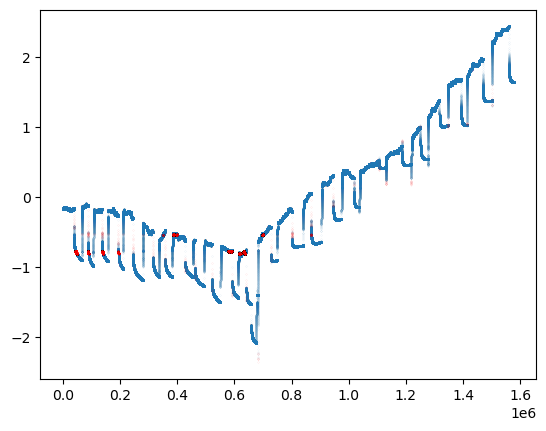

len of intervals is: 0
      start     stop
0     13356    13365
1     13376    13391
2     33662    33668
3     33678    33697
4     59881    59889
..      ...      ...
93  1184513  1184514
94  1184519  1184520
95  1184525  1184546
96  1184684  1184684
97  1184703  1184710

[98 rows x 2 columns]
len of intervals is: 0


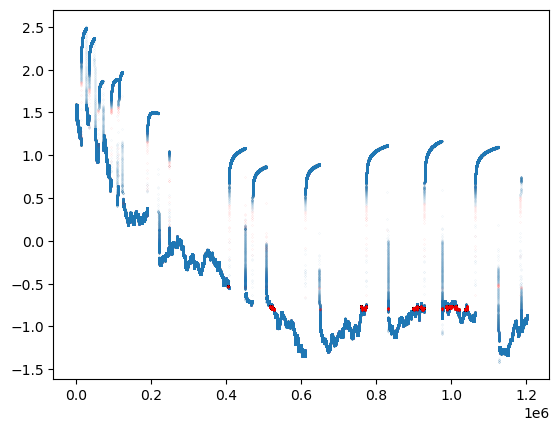

len of intervals is: 0
       start     stop
0      13985    13991
1      21050    21058
2      21061    21061
3      21066    21186
4      23239    29008
..       ...      ...
200  1516367  1516368
201  1516371  1516384
202  1516386  1516510
203  1517473  1527279
204  1527416  1527481

[205 rows x 2 columns]
len of intervals is: 0


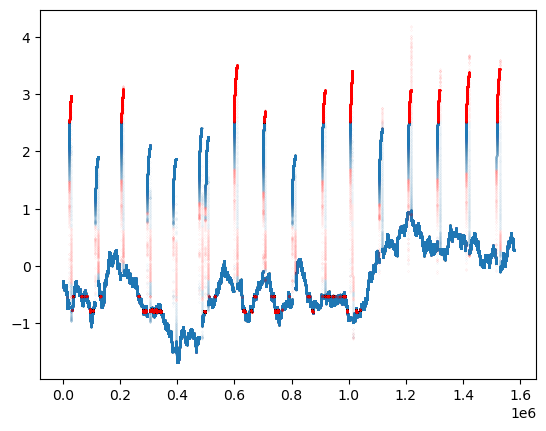

len of intervals is: 0
       start     stop
0          0      915
1       8199     8607
2      37449    37449
3      62788    62964
4      83259    83259
..       ...      ...
122  1433882  1433896
123  1434172  1434252
124  1456741  1456745
125  1499830  1499849
126  1524894  1524897

[127 rows x 2 columns]
len of intervals is: 0


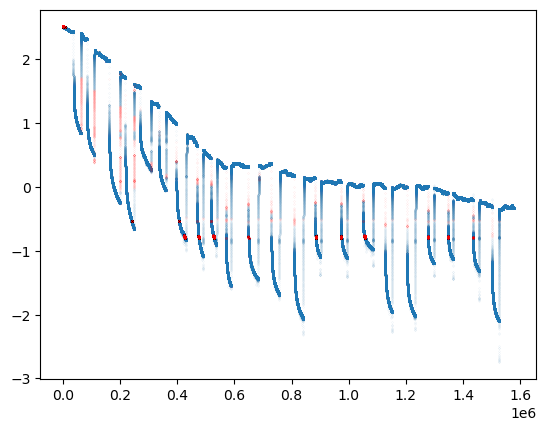

len of intervals is: 0
       start     stop
0       1028     1072
1       2833     2981
2       4211     4216
3       8567     8709
4      15550    18831
..       ...      ...
179  1548326  1548329
180  1548331  1548462
181  1551179  1557640
182  1557904  1557916
183  1557919  1557921

[184 rows x 2 columns]
len of intervals is: 0


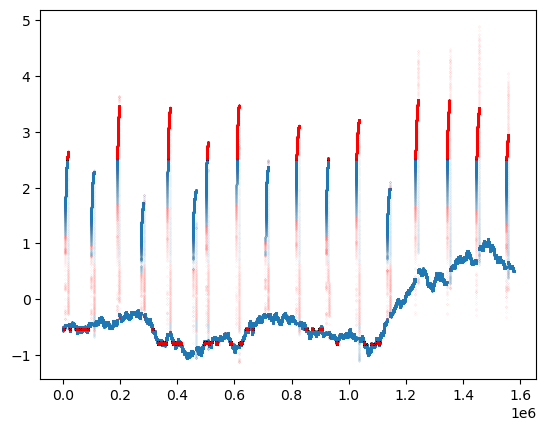

len of intervals is: 0
       start     stop
0      30858    30867
1      51681    51682
2      53600    53897
3      58279    58279
4      58324    58461
..       ...      ...
121  1417703  1417706
122  1465733  1465756
123  1494008  1494011
124  1541112  1541133
125  1563981  1563985

[126 rows x 2 columns]
len of intervals is: 0


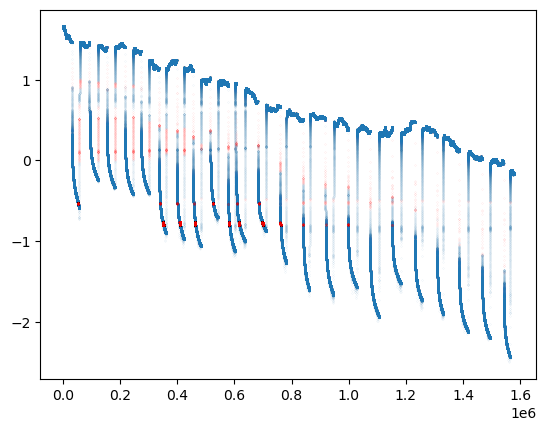

len of intervals is: 0
       start     stop
0       4203     4209
1       4211     4371
2      33530    33530
3      33947    34131
4      34303    34317
..       ...      ...
386  1560436  1560438
387  1560549  1560556
388  1560922  1560924
389  1561215  1561222
390  1566678  1566679

[391 rows x 2 columns]
len of intervals is: 0


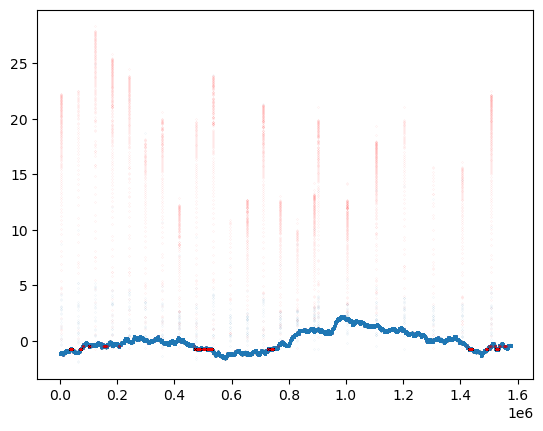

len of intervals is: 0
       start     stop
0      17151    17162
1      17169    17171
2      17173    17173
3      17182    17201
4      17207    17254
..       ...      ...
341  1488466  1488582
342  1488629  1488639
343  1488694  1488698
344  1497594  1498109
345  1505795  1506267

[346 rows x 2 columns]
len of intervals is: 0


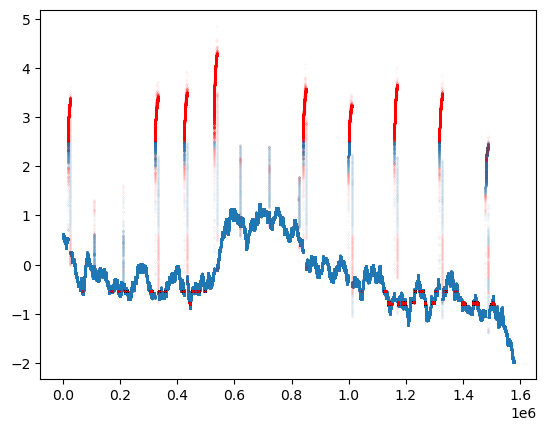

len of intervals is: 0
       start     stop
0       5827     5836
1       5848     5850
2       5859     5950
3       5980     6010
4      13411    13411
..       ...      ...
862  1572298  1572302
863  1572384  1572386
864  1572474  1572488
865  1574570  1574572
866  1574989  1575048

[867 rows x 2 columns]
len of intervals is: 0


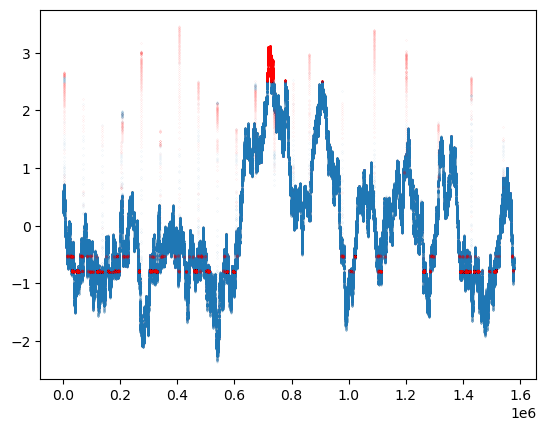

len of intervals is: 0
      start     stop
0     55622    55632
1     55640    55656
2    169830   169837
3    169843   169843
4    169847   169847
..      ...      ...
63  1364749  1364749
64  1489621  1489621
65  1489633  1489634
66  1489637  1489644
67  1528644  1528644

[68 rows x 2 columns]
len of intervals is: 0


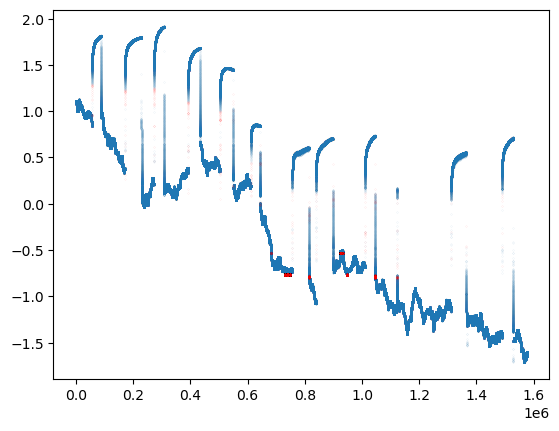

len of intervals is: 0
      start     stop
0     48406    48415
1     48423    48450
2    153272   153280
3    153291   153324
4    217641   217650
5    217658   217685
6    326004   326016
7    326019   326043
8    472572   472631
9    472633   472633
10   597238   597252
11   597254   597272
12   643787   643792
13   668906   670039
14   670279   670764
15   707677   707678
16   761692   761709
17   762075   762079
18   762396   762423
19   792377   792381
20   830213   830229
21   830663   830672
22   871744   871755
23  1023743  1023754
24  1144480  1144483
25  1185386  1185403
26  1185743  1185762
27  1261910  1261911
28  1262047  1262061
29  1262136  1262143
30  1457360  1457362
31  1494823  1494839
32  1495262  1495272
len of intervals is: 0


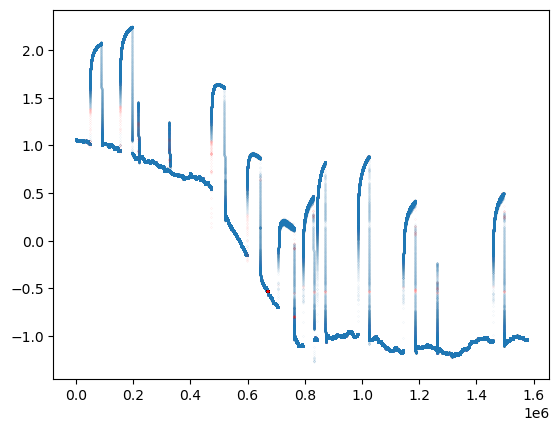

In [ ]:
for df in prediction_dfs:
    #print(df)
    interval = df_to_intervals(df)
    print(interval)
    visualize_well(df)

# 20 sliding window with only one sigmoid output

In [21]:
window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count,True)
X, y_regression, y_classification = process_multiple_dataframes(data, window_size)

# Define the model with separate output layers
input_layer = Input(shape=(window_size,))
dense_1 = Dense(64, activation='relu')(input_layer)
dense_2 = Dense(32, activation='relu')(dense_1)

#output_regression = Dense(1, name='regression_output')(dense_2)
output_classification = Dense(1, activation='sigmoid', name='classification_output')(dense_2)

model = Model(inputs=input_layer, outputs=output_classification)
# Define precision and recall metrics
precision = Precision()
recall = Recall()
# Compile the model with separate losses and metrics
model.compile(optimizer=Adam(),
              loss={'classification_output': binary_crossentropy},
              metrics=['accuracy', precision, recall])

# Train the model
model.fit(X, y_classification, epochs=5, batch_size=32)


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
Epoch 1/5
197098/197098 [==============================] - 142s 716us/step - loss: 0.3692 - accuracy: 0.8378 - precision_2: 0.5603 - recall_2: 0.0533
Epoch 2/5
197098/197098 [==============================] - 138s 702us/step - loss: 0.3633 - accuracy: 0.8383 - precision_2: 0.5705 - recall_2: 0.0597
Epoch 3/5
197098/197098 [==============================] - 137s 694us/step - loss: 0.3600 - accuracy: 0.8388 - precision_2: 0.5711 - recall_2: 0.0694
Epoch 4/5
197098/197098 [==============================] - 135s 686us/step - loss: 0.3564 - accuracy: 0.8391 - precision_2: 0.5723 - recall_2: 0.0767
Epoch 5/5
197098/197098 [==============================] - 136s 690us/step - loss: 0.3284 - accuracy: 0.8507 - precision_2: 0.6107 - recall_2: 0.2476


# Prediction

In [ ]:
# Define a function to predict on new dataframes and return results as dataframes
def predict_on_dataframes(model, dataframes, window_size):
    prediction_dfs = []
    for df in dataframes:
        #print(df)
        name = df.iloc[0]['name']
        df = df.drop(columns=['name'])
        y_array = df['y'].values
        red_array = df['red'].values
        X, _ = create_sliding_window_np(y_array, window_size)
        y_pred_regression, y_pred_classification = model.predict(X)
        y_pred_classification = (y_pred_classification > 0.5).astype(int)
        # Create a new dataframe with predictions
        prediction_df = pd.DataFrame({
            'name': name,
            'y': y_pred_regression.flatten(),
            'red': y_pred_classification.flatten()
        })
        
        prediction_dfs.append(prediction_df)
    
    return prediction_dfs

path_test = "spot-the-trend-test-data"
data_count = 11
new_data = read_data(path_test,data_count,False)

prediction_dfs = predict_on_dataframes(model, new_data, window_size)
for df in prediction_dfs:
    #print(df)
    interval = df_to_intervals(df)
    print(interval)
    visualize_well(df)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           1344        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                                  
 regression_output (Dense)      (None, 1)            33          ['dense_1[0][0]']                
                                                                                              

# UNDER DEVELOPMENT

In [ ]:
def red_blue_intervals(ts,intervals):
    blue = []
    red = []
    blue.append(ts.iloc[0:intervals['start'][0]])
    #print(len(blue))
    for i in range(len(intervals)-1):
        blue.append(ts.iloc[intervals['stop'][i]:intervals['start'][i+1]])
    blue.append(ts.iloc[intervals['stop'][len(intervals)-1]:len(ts)])
    
    for i in range(len(intervals)):
        red.append(ts.iloc[intervals['start'][i]:intervals['stop'][i]])
    blue = pd.concat(blue, ignore_index=False)
    red = pd.concat(red, ignore_index=False)
    return red, blue
test_data = []
for df in prediction_dfs:
    intervals = df_to_intervals(df)
    print(df['red'].any())
    print(intervals)
    # new_df = integrate_intervals(df,intervals)
    # test_data.append(new_df)
    r,b = red_blue_intervals(df,intervals)
    plt.scatter(b.index,b['y'], s=0.001)
    plt.scatter(r.index,r['y'],c='r', s=0.001)
    plt.title(file)
    # plt.savefig("visualisations/"+file.replace('.csv','')+'.png', bbox_inches='tight', dpi=500)
    plt.show()
    plt.close('all')
    gc.collect()


0
False
[]


TypeError: list indices must be integers or slices, not str

# The code for a neural network to predict only 'red'

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
from keras.metrics import MeanSquaredError, BinaryAccuracy
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam

def create_sliding_window_np(y_array, red_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, 2 * window_size))
    y_regression = np.empty((num_windows, 1))
    y_classification = np.empty((num_windows, 1))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :window_size] = y_array[i:i + window_size]
        X[i, window_size:] = red_array[i:i + window_size]
        y_regression[i] = y_array[i + window_size]
        y_classification[i] = red_array[i + window_size]
    
    return X, y_regression, y_classification

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_regression_total = []
    y_classification_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values
        X, y_regression, y_classification = create_sliding_window_np(y_array, red_array, window_size)
        X_total.append(X)
        y_regression_total.append(y_regression)
        y_classification_total.append(y_classification)

    X_total = np.vstack(X_total)
    y_regression_total = np.vstack(y_regression_total).flatten()
    y_classification_total = np.vstack(y_classification_total).flatten()

    return X_total, y_regression_total, y_classification_total


window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count)
X, y_regression, y_classification = process_multiple_dataframes(data, window_size)

# Define the model with a single output layer for classification
input_layer = Input(shape=(2 * window_size,))
dense_1 = Dense(64, activation='relu')(input_layer)
dense_2 = Dense(32, activation='relu')(dense_1)

output_classification = Dense(1, activation='sigmoid', name='classification_output')(dense_2)

model = Model(inputs=input_layer, outputs=output_classification)

# Compile the model with classification loss and metrics
model.compile(optimizer=Adam(),
              loss=binary_crossentropy,
              metrics=[BinaryAccuracy()])

# Train the model
model.fit(X, y_classification, epochs=4, batch_size=32)

# Predict the red values
y_classification_pred = model.predict(X)

# Evaluate the model for classification
classification_loss, classification_accuracy = model.evaluate(X, y_classification)
print(f"Classification Loss: {classification_loss}, Classification Accuracy: {classification_accuracy}")

# Evaluate the model for regression (y) separately using MSE
mse = MeanSquaredError()
y_regression_pred = np.zeros_like(y_regression)  # Dummy predictions for y
mse.update_state(y_regression, y_regression_pred)
mse_value = mse.result().numpy()
print(f"Mean Squared Error for y: {mse_value}")


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
Epoch 1/4
197098/197098 [==============================] - 84s 425us/step - loss: 0.6113 - binary_accuracy: 0.8466
Epoch 2/4
197098/197098 [==============================] - 83s 421us/step - loss: 0.4464 - binary_accuracy: 0.8359
Epoch 3/4
197098/197098 [==============================] - 84s 426us/step - loss: 0.4464 - binary_accuracy: 0.8359
Epoch 4/4
197098/197098 [==============================] - 54s 274us/step - loss: 0.4458 - binary_accuracy: 0.8359
Classification Loss: 0.4458426833152771, Classification Accuracy: 0.8359227776527405
Mean Squared Error for y: 12297343.0


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

window_size = 20
path = "spot-the-trend-train-data"
data_count = 4
data = read_data(path,data_count)

# train = np.array([df['y'].to_numpy() for df in data])
# train = np.concatenate(train)
# train = train.flatten().flatten()
# print(train.shape)


# Create input-output pairs
# def create_sliding_window(df, window_size):
#     print('yo')
#     data = df['y'].to_numpy()
#     label = df['red'].to_numpy()
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         # if i%100 == 0:
#         #     print(i)
#         # X.append(list(zip(data[i:i + window_size],label[i:i+window_size])))
#         X.append(data[i:i + window_size])
#         X.append(label[i:i + window_size])
#         y.append(data[i + window_size])
#         y.append(label[i+window_size])
#     print('done')
#     return np.array(X), np.array(y)


# def create_sliding_window(data, window_size):
#     num_windows = len(data) - window_size
    
#     # Create empty arrays to hold the windows
#     X = np.empty((num_windows, 2 * window_size))
#     y = np.empty((num_windows, 2))
    
#     # Use numpy's efficient array slicing
#     for i in range(window_size, len(data)):
#         if i%100000==0:
#             print(i)
#         window_start = i - window_size
#         X[i - window_size, :window_size] = data['y'].iloc[window_start:i]
#         X[i - window_size, window_size:] = data['red'].iloc[window_start:i]
#         y[i - window_size] = [data['y'].iloc[i], data['red'].iloc[i]]
    
#     return X, y

def create_sliding_window_np(y_array, red_array, window_size):
    num_windows = len(y_array) - window_size
    
    # Initialize numpy arrays to hold the windows
    X = np.empty((num_windows, 2 * window_size))
    y = np.empty((num_windows, 2))
    
    # Use numpy's efficient array slicing
    for i in range(num_windows):
        X[i, :window_size] = y_array[i:i + window_size]
        X[i, window_size:] = red_array[i:i + window_size]
        y[i] = [y_array[i + window_size], red_array[i + window_size]]
    
    return X, y

def process_multiple_dataframes(dataframes, window_size):
    X_total = []
    y_total = []

    for df in dataframes:
        y_array = df['y'].values
        red_array = df['red'].values
        X, y = create_sliding_window_np(y_array, red_array, window_size)
        X_total.append(X)
        y_total.append(y)

    X_total = np.vstack(X_total)
    y_total = np.vstack(y_total)

    return X_total, y_total

    
# print(type(train[0]))
# ys = np.array([df['y'].to_numpy() for df in train])
# labels = np.array([df['red'].to_numpy() for df in train])
# X, y = [], []
# for d in data:
#     Xtemp, ytemp = create_sliding_window(d, window_size)
#     X.append(Xtemp)
#     y.append(ytemp)

X, y = process_multiple_dataframes(data, window_size)


# print(X,y)

# X = np.array(X).flatten()
# y = np.array(y).flatten()

print(type(X))
print(len(X))
print(type(y))
print(len(y))

print(np.isnan(X).any())  # Should be False
print(np.isnan(y).any())  # Should be False

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#print()
#print(r2_score(X_train,y_train))
#print(r2_score(X_test,y_test))
#print()

print(np.isnan(X_train).any())  # Should be False
print(np.isnan(y_train).any())  # Should be False
print(np.isinf(X_train).any())  # Should be False
print(np.isinf(y_train).any())  # Should be False

# Define and compile the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2 * window_size,)),
    Dense(32, activation='relu'),
    Dense(2)  # Output layer with 2 neurons for y and red
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=4, batch_size=32)

# Ensure the data is of type float
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')

# # Define the model
# model = Sequential()
# model.add(Dense(40, activation='relu', input_shape=(window_size,)))
# model.add(Dense(2))
# model.compile(optimizer='adam', loss='mse')

# # Train the model
# history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), verbose=1)

# # Evaluate the model
# loss = model.evaluate(X_test, y_test, verbose=0)
# print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


uopfk.csv
mlhdp.csv
ogfyy.csv
pltbp.csv
<class 'numpy.ndarray'>
6307116
<class 'numpy.ndarray'>
6307116
False
False
False
False
False
False
Epoch 1/4
109511/197098 [===============>..............] - ETA: 56s - loss: 598.1847

KeyboardInterrupt: 

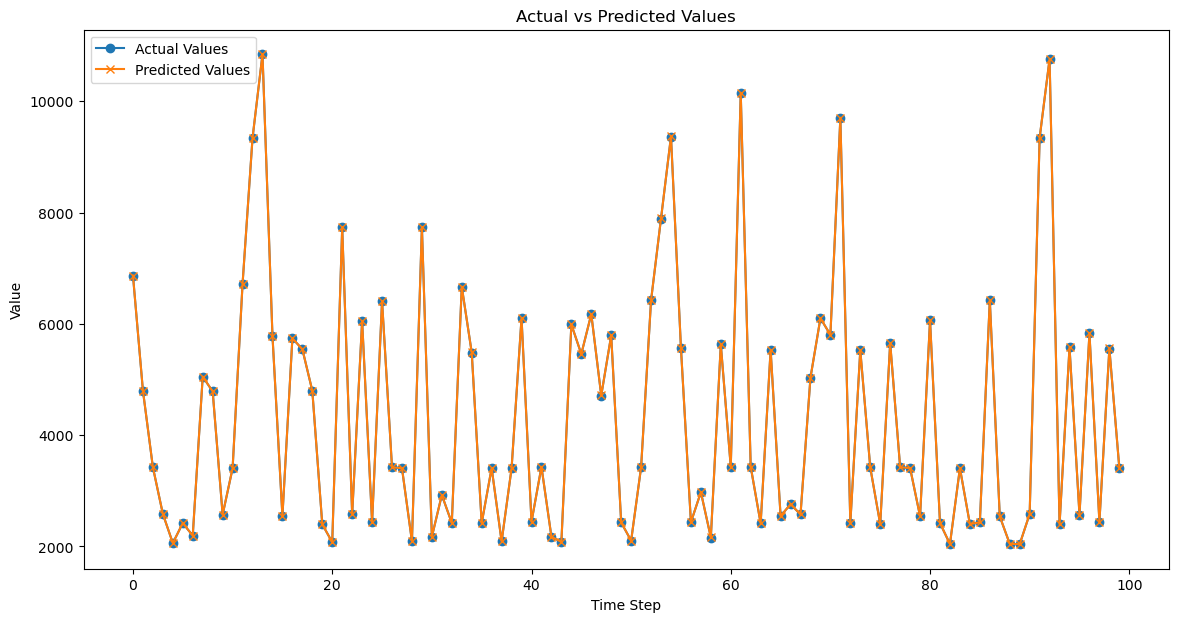

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

plt.figure(figsize=(14, 7))
plt.plot(y_test[1000:1100], label='Actual Values', marker='o')
plt.plot(predictions[1000:1100], label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()